# Reassign DecisionTree leaves by $\Delta$IA

## Load Balrog-Bagpipes catalog

In [1]:
import pickle

In [2]:
file = '/global/cfs/cdirs/des/elisa/ShearSplits_data/balrog-bagpipes.pkl'
data = pickle.load(open(file, 'rb'), encoding='latin1')
print(f'Length of Balrog-Bagpipes catalog: {len(data)}')

Length of Balrog-Bagpipes catalog: 2417437


In [3]:
data = data.dropna(subset=['stell_best', 'ssfr_best'])
print(f'Length of Balrog-Bagpipes catalog (no nan): {len(data)}')

Length of Balrog-Bagpipes catalog (no nan): 2417396


In [4]:
for i in range(4):
    print(f"Length of Balrog-Bagpipes Bin{i}: {len(data[data['bin']==i])}")

Length of Balrog-Bagpipes Bin0: 613544
Length of Balrog-Bagpipes Bin1: 608122
Length of Balrog-Bagpipes Bin2: 605458
Length of Balrog-Bagpipes Bin3: 590272


## Load DecisionTrees and train/test samples, predictions

In [5]:
import joblib
import pandas as pd

In [6]:
decisiontree_dir = '/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/'
decisiontree_file_template = decisiontree_dir + 'decisiontree_bin{}.joblib'

classifiers = {}

for i in range(4):
    print(f'Loading DecisionTree Bin{i}')
    classifiers[i] = joblib.load(decisiontree_file_template.format(i))

Loading DecisionTree Bin0


/global/homes/e/elegnani/.conda/envs/cosmo_env/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading DecisionTree Bin1
Loading DecisionTree Bin2
Loading DecisionTree Bin3


In [7]:
file = '/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/decisiontree_predictions.pkl'
predictions = pickle.load(open(file, 'rb'), encoding='latin1')
print(f'Length of predictions catalog: {len(predictions)}')

# Add predictions to data
data = pd.merge(data, predictions, on='bal_id', how='inner') # Oss: checked it does it correctly

Length of predictions catalog: 2417396


In [8]:
for i in range(4):
    X_test = data[(data['bin'] == i) & (data['label_pred'] != -1)]
    print(f'Bin{i}')
    print(f"- Number of blue galaxies: {len(X_test[X_test['label_pred']==0])}")
    print(f"- Number of red galaxies:  {len(X_test[X_test['label_pred']==1])}")
    print(f'Number of leaves: {classifiers[i].get_n_leaves()}')
    print()

Bin0
- Number of blue galaxies: 67964
- Number of red galaxies:  54745
Number of leaves: 2910

Bin1
- Number of blue galaxies: 66327
- Number of red galaxies:  55298
Number of leaves: 3145

Bin2
- Number of blue galaxies: 64137
- Number of red galaxies:  56955
Number of leaves: 3072

Bin3
- Number of blue galaxies: 67719
- Number of red galaxies:  50336
Number of leaves: 3091



## Produce table with `leaf_id`, `label`, and properties to compute SNR

In [9]:
import numpy as np
import nz_utils as nz
from split_IA import *

In [10]:
Responses = {}
for i in range(4):
    Responses[i] = np.mean(data[data['bin']==i]['unsheared/R11']+data[data['bin']==i]['unsheared/R22'])/2.
print('Avg response', Responses)

Avg response {0: 0.7475089113672887, 1: 0.7088164619554643, 2: 0.6866178168646271, 3: 0.5944905021663858}


In [11]:
def get_mapping(classifier, X_train, Response):

    # mapping leaf_id - label
    leaf_ids = np.where(classifier.tree_.children_left == -1)[0]
    leaf_labels = [np.argmax(classifier.tree_.value[leaf][0]) for leaf in leaf_ids]
    leaf_df = pd.DataFrame({
        'leaf_id': leaf_ids,
        'label': leaf_labels
    })
    
    # save bal_ids of the training sdample that fall into each leaf
    flux_columns = ['unsheared/flux_i', 'unsheared/flux_r', 'unsheared/flux_z']
    leaf_assignments = classifier.apply(X_train[flux_columns]) # re-apply to train dataset
    df_with_leaf = X_train.copy()
    df_with_leaf['leaf_id'] = leaf_assignments
    
    bal_ids = df_with_leaf.groupby('leaf_id')['bal_id'].apply(list)
    leaf_df = leaf_df.merge(bal_ids, on='leaf_id', how='left')

    counts = bal_ids.apply(len).rename('n_train_objects')
    leaf_df = leaf_df.merge(counts, on='leaf_id', how='left')
    
    empty_leaves = leaf_df[leaf_df['bal_id'].isna()]
    if not empty_leaves.empty:
        print('Empty leaves:', empty_leaves['leaf_id'].to_numpy())

    df_with_leaf['sum_w2e2_1'] = (df_with_leaf['unsheared/weight'] ** 2) * ((df_with_leaf['unsheared/e_1'] / Response) ** 2)
    df_with_leaf['sum_w2e2_2'] = (df_with_leaf['unsheared/weight'] ** 2) * ((df_with_leaf['unsheared/e_2'] / Response) ** 2)
    df_with_leaf['sum_w'] = df_with_leaf['unsheared/weight']
    df_with_leaf['sum_w2'] = df_with_leaf['unsheared/weight'] ** 2
    
    df_with_leaf['stell_mean'] = df_with_leaf['stell_best']

    aggregations = {
        'sum_w2e2_1': 'sum',
        'sum_w2e2_2': 'sum',
        'sum_w': 'sum',
        'sum_w2': 'sum',
        'pzc_weighted': 'mean',
        'stell_mean': 'mean',
    }
    
    stats = df_with_leaf.groupby('leaf_id').agg(aggregations).reset_index()
    leaf_df = leaf_df.merge(stats, on='leaf_id', how='left')

    len_pileup = 300
    z3 = np.linspace(0, 2.99, len_pileup)

    pz_per_leaf = df_with_leaf.groupby('leaf_id')['pzc_weighted'].apply(
        lambda x: np.mean(np.stack(x.to_numpy()), axis=0)
    )
    pz_pileup_smooth = pz_per_leaf.apply(lambda pz: nz.pileup_smooth_normalize(pz, z3))
    pz_pileup_smooth_df = pd.DataFrame({
        'leaf_id': pz_pileup_smooth.index,
        'pz_pileup_smooth': pz_pileup_smooth.values
    })

    z_means = pz_pileup_smooth_df['pz_pileup_smooth'].apply(nz.mean_z) # Use median instead
    pz_pileup_smooth_df['z_mean'] = z_means

    leaf_df = leaf_df.merge(pz_pileup_smooth_df, on='leaf_id', how='left')

    leaf_df['density'] = leaf_df.apply(lambda row: get_density(np.array([row['sum_w']]), np.array([row['sum_w2']])), axis=1)
    leaf_df['shape_noise'] = leaf_df.apply(lambda row: get_shape_noise(np.array([row['sum_w2e2_1']]), np.array([row['sum_w2e2_2']]), np.array([row['sum_w']]), np.array([row['sum_w2']])), axis=1)
    
    return leaf_df

In [12]:
leaf_df = {}
for i in range(4):
    clf = classifiers[i]
    X_train = data[(data['bin'] == i) & (data['label_pred'] == -1)]
    R = Responses[i]

    leaf_df[i] = get_mapping(clf, X_train, R)
    leaf_df[i].to_pickle(f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/leaf-label_bin{i}.pkl')

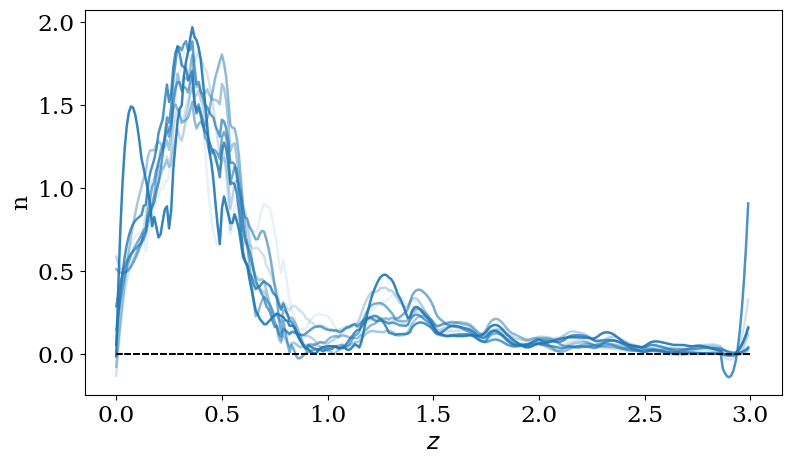

In [14]:
from plot_utils import *

len_pileup = 300
z3 = np.linspace(0, 2.99, len_pileup)
fig = plt.figure(figsize=(9, 5))
for i in range(10):
    plt.plot(z3, leaf_df[0]['pz_pileup_smooth'][i+200], alpha=i/10, color='tab:blue') # OK to have negative values and some big pile-up?
    plt.hlines(0, 0, 3, ls='--', lw=1.2, color='k')
    plt.xlabel(r'$z$')
    plt.ylabel('n')
plt.show()

## Load table with `leaf_id`, `label`, and properties to compute SNR

In [9]:
import numpy as np
import nz_utils as nz
from split_IA import *
from plot_utils import *

In [10]:
leaf_df = {}
for i in range(4):
    file = f'/global/cfs/cdirs/des/elisa/ShearSplits_data/decisiontree/leaf-label_bin{i}.pkl'
    leaf_df[i] = pickle.load(open(file, 'rb'), encoding='latin1')

## Prepare cosmosis and covariance runs

### Compute fixed cosmological parameters and cov($\Omega_m$, $A_s$) from Planck's chain

In [11]:
from getdist import loadMCSamples, plots
%matplotlib inline

['omegabh2', 'omegach2', 'theta', 'tau', 'logA', 'ns', 'calPlanck', 'amp_143', 'amp_217', 'amp_143x217', 'n_143', 'n_217', 'n_143x217', 'calTE', 'calEE', 'H0', 'omegal', 'omegam', 'omegamh2', 'omegamh3', 'sigma8', 'S8', 's8omegamp5', 's8omegamp25', 's8h5', 'rdragh', 'rmsdeflect', 'zrei', 'A', 'clamp', 'DL40', 'DL220', 'DL810', 'DL1420', 'DL2000', 'ns02', 'yheused', 'YpBBN', 'DHBBN', 'age', 'zstar', 'rstar', 'thetastar', 'DAstar', 'zdrag', 'rdrag', 'kd', 'thetad', 'zeq', 'keq', 'thetaeq', 'thetarseq', 'Hubble015', 'DM015', 'Hubble038', 'DM038', 'Hubble051', 'DM051', 'Hubble061', 'DM061', 'Hubble233', 'DM233', 'fsigma8z015', 'sigma8z015', 'fsigma8z038', 'sigma8z038', 'fsigma8z051', 'sigma8z051', 'fsigma8z061', 'sigma8z061', 'fsigma8z233', 'sigma8z233', 'f2000_143', 'f2000_217', 'f2000_x', 'chi2_lowl', 'chi2_simall', 'chi2_CamSpec', 'chi2_prior', 'chi2_CMB']


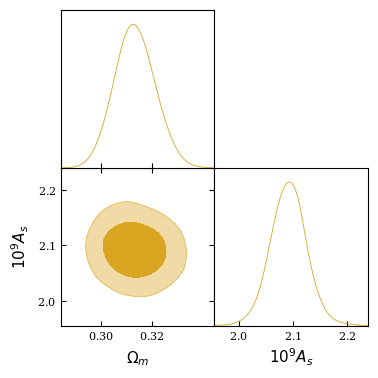

In [12]:
chain = loadMCSamples('cosmosis_runs/planck_chains/base_v12_5HMcln_TTTEEE_lowl_lowE') #from Efstathiou & Gratton 2021 TTTEEE

param_names = chain.getParamNames().list()
params = chain.getParams()

print(param_names)

omega_m = params.omegam
A_s = params.A
tau = params.tau
H0 = params.H0
n_s = params.ns
omega_b_h2 = params.omegabh2
omega_c_h2 = params.omegach2
weights = chain.weights

g = plots.get_subplot_plotter()
g.triangle_plot(chain, ['omegam', 'A'], filled=True, contour_colors=['goldenrod'])

plt.show()

In [13]:
fixed_params = {
    'h0': np.average(H0/100, weights=weights),
    'ombh2': np.average(omega_b_h2, weights=weights),
    'n_s': np.average(n_s, weights=weights),
    'w': -1.0,
    'omega_k': 0.0,
    'tau': np.average(tau, weights=weights),
    'standard_neutrino_neff': 3.044,
    'num_massive_neutrinos': 3,
    'nnu': 3.044,
    'mnu': 0.06,
}

print('fixed cosmological parameters:')
for key, value in fixed_params.items():
    print(f'   {key}: {value:.6f}')

# Deltas and means Omega_m, A_s
delta_params = [0.01, 0.01e-9]
param_names = ['omega_m', 'A_s']
param_means = [np.average(omega_m, weights=weights), np.average(A_s*1e-9, weights=weights)]

def write_cosmo(label, omega_m_val, As_val):
    filename = f'cosmosis_runs/cosmosis_config/values_cosmo_planck{label}.ini'
    print(f'{label} {param_names[0]}: {omega_m_val:.6f}, {param_names[1]}: {As_val:.6e}')
    with open(filename, 'w') as f:
        f.write('%include /global/u1/e/elegnani/ShearSplits/cosmosis_runs/cosmosis_config/values.ini\n')
        f.write('\n')
        f.write('[cosmological_parameters]\n')
        f.write(f"omega_m                =  {omega_m_val:.6f}\n")
        f.write(f"A_s                    =  {As_val:.6e}\n")
        f.write(f"h0                     =  {fixed_params['h0']:.6f}\n")
        f.write(f"ombh2                  =  {fixed_params['ombh2']:.6f}\n")
        f.write(f"n_s                    =  {fixed_params['n_s']:.6f}\n")
        f.write(f"w                      =  {fixed_params['w']}\n")
        f.write(f"omega_k                =  {fixed_params['omega_k']}\n")
        f.write(f"tau                    =  {fixed_params['tau']:.6f}\n")
        f.write('\n')
        f.write(f"standard_neutrino_neff =  {fixed_params['standard_neutrino_neff']:.6f}\n")
        f.write(f"num_massive_neutrinos  =  {fixed_params['num_massive_neutrinos']:.6f}\n")
        f.write(f"nnu                    =  {fixed_params['nnu']:.6f}\n")
        f.write(f"mnu                    =  {fixed_params['mnu']:.6f}\n")

# Central values
write_cosmo('', param_means[0], param_means[1])

# ± delta for omega_m (A_s fixed)
for sign in [-1, 1]:
    om_val = param_means[0] + sign * delta_params[0]
    label = f"_{'+' if sign > 0 else '-'}dOm"
    write_cosmo(label, om_val, param_means[1])

# ± delta for A_s (omega_m fixed)
for sign in [-1, 1]:
    As_val = param_means[1] + sign * delta_params[1]
    label = f"_{'+' if sign > 0 else '-'}dAs"
    write_cosmo(label, param_means[0], As_val)

fixed cosmological parameters:
   h0: 0.674461
   ombh2: 0.022263
   n_s: 0.967141
   w: -1.000000
   omega_k: 0.000000
   tau: 0.053478
   standard_neutrino_neff: 3.044000
   num_massive_neutrinos: 3.000000
   nnu: 3.044000
   mnu: 0.060000
 omega_m: 0.313436, A_s: 2.092086e-09
_-dOm omega_m: 0.303436, A_s: 2.092086e-09
_+dOm omega_m: 0.323436, A_s: 2.092086e-09
_-dAs omega_m: 0.313436, A_s: 2.082086e-09
_+dAs omega_m: 0.313436, A_s: 2.102086e-09


In [14]:
def weighted_cov(x, y, w):
    avg_x = np.average(x, weights=w)
    avg_y = np.average(y, weights=w)
    cov_xy = np.average((x - avg_x) * (y - avg_y), weights=w)
    var_x = np.average((x - avg_x)**2, weights=w)
    var_y = np.average((y - avg_y)**2, weights=w)
    return np.array([[var_x, cov_xy], [cov_xy, var_y]])

cov_Om_As = weighted_cov(omega_m, A_s*1e-9, weights)
# cov_Om_As = np.cov(omega_m, A_s) # Unweighted covariance

print('Covariance matrix between Omega_m and A_s:')
print(cov_Om_As)

np.savetxt('cosmosis_runs/cov_Om_As.txt', cov_Om_As, fmt='%.6e')

Covariance matrix between Omega_m and A_s:
[[ 6.40386260e-05 -2.59987624e-14]
 [-2.59987624e-14  1.15500001e-21]]


### Save files with n(z)s and mean stellar masses

Mean stellar mass:

 - Blue: 8.99
 - Red:  9.98

 - Blue: 9.27
 - Red:  10.34

 - Blue: 9.74
 - Red:  10.66

 - Blue: 9.69
 - Red:  10.56



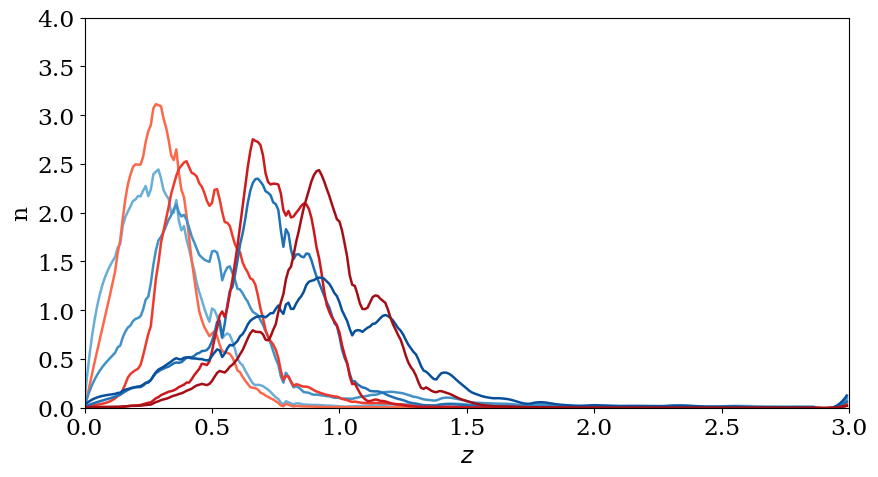

In [11]:
fig = plt.figure(figsize=(9, 5))
ax = fig.gca()

len_pileup = 300
z3 = np.linspace(0, 2.99, len_pileup)

print('Mean stellar mass:\n')

# Original binning
for i in range(4):
    output_dir = f'cosmosis_runs/bin{i}/full'

    leaf_df_i = leaf_df[i]
    leaf_df1 = leaf_df_i[leaf_df_i['label'] == 0]
    leaf_df2 = leaf_df_i[leaf_df_i['label'] == 1]

    # Write n(z)s and mean stellar masses to files
    
    pz1 = np.sum(leaf_df1['pzc_weighted'] * leaf_df1['n_train_objects'], axis=0) / np.sum(leaf_df1['n_train_objects'])
    pz2 = np.sum(leaf_df2['pzc_weighted'] * leaf_df2['n_train_objects'], axis=0) / np.sum(leaf_df2['n_train_objects'])

    nz1 = nz.pileup_smooth_normalize(pz1, z3)
    nz2 = nz.pileup_smooth_normalize(pz2, z3)

    ax.plot(z3, nz1, color=matplotlib.colormaps['Blues'](0.5 + i/8))
    ax.plot(z3, nz2, color=matplotlib.colormaps['Reds'](0.5 + i/8))
    
    write_nz_file(nz1, nz2, output_dir)
    
    stell_mean1 = np.sum(leaf_df1['stell_mean'] * leaf_df1['n_train_objects']) / np.sum(leaf_df1['n_train_objects'])
    stell_mean2 = np.sum(leaf_df2['stell_mean'] * leaf_df2['n_train_objects']) / np.sum(leaf_df2['n_train_objects'])

    print(f' - Blue: {stell_mean1:.2f}')
    print(f' - Red:  {stell_mean2:.2f}\n')
    
    np.savetxt(f'{output_dir}/stellar_mass_mean.txt', [stell_mean1, stell_mean2], fmt='%.6e')

    # Write covariance config file

    density1 = get_density(leaf_df1['sum_w'], leaf_df1['sum_w2'])
    density2 = get_density(leaf_df2['sum_w'], leaf_df2['sum_w2'])
    
    shape_noise1 = get_shape_noise(leaf_df1['sum_w2e2_1'], leaf_df1['sum_w2e2_2'], leaf_df1['sum_w'], leaf_df1['sum_w2'])
    shape_noise2 = get_shape_noise(leaf_df2['sum_w2e2_1'], leaf_df2['sum_w2e2_2'], leaf_df2['sum_w'], leaf_df2['sum_w2'])

    log_normal_shift = get_log_normal_shift(i)
    
    with open('cosmosis_runs/CosmoLike_config_demo.txt', 'rt') as f:
        config = f.read()
        config = config.replace('density1', str(density1))
        config = config.replace('density2', str(density2))
        config = config.replace('shape-noise1', str(shape_noise1))
        config = config.replace('shape-noise2', str(shape_noise2))
        config = config.replace('log-normal-shift-zbin', str(log_normal_shift))
        f.close()
        
    with open(f'{output_dir}/CosmoLike_config.txt', 'wt') as f:
        f.write(config)
        f.close()
    
axis_settings(ax, z_params)
ax.set_ylim(0, 4)

plt.tight_layout()
fig.patch.set_alpha(1.0)
plt.show()

In [ ]:
    # Change each leaf_id label and re-compute nzs, stellar masses, density, shape_noise
    #for i in leaf_ids:
    #    output_dir = f'cosmosis_runs/bin{i}/leaf_{leaf_id}'
    #    nz1 = 
    #    nz2 = 
    #    write_nz_file(nz1, nz2, output_dir)
    #    stell_mean1 = 
    #    stell_mean2 = 
    #    np.savetxt(f'{output_dir}/stellar_mass_mean.txt', stell_mean, fmt='%.6e')

## Run cosmosis

In [ ]:
import subprocess

cosmo_labels = ['planck', 'planck_+dOm', 'planck_-dOm', 'planck_+dAs', 'planck_-dAs']

for i in range(4):
    for cosmo_label in cosmo_labels:
        print(f'Bin{i}, {cosmo_label} cosmology')

        input_dir = f'bin{i}/full'
        output_dir = f'bin{i}/full/shear_{cosmo_label}'
        cosmo_values = f'values_cosmo_{cosmo_label}.ini'

        with open('cosmosis_runs/submit_cosmosis_demo.sh', 'r') as f:
            config = f.read()
            config = config.replace('input_dir', input_dir)
            config = config.replace('output_dir', output_dir)
            config = config.replace('values_cosmo.ini', cosmo_values)
            f.close()

        script_file = 'cosmosis_runs/submit_cosmosis.sh'
        with open(script_file, 'wt') as f:
            f.write(config)
            f.close()

        # Make it executable
        subprocess.run(['chmod', '+x', script_file])

        # Run the script without printing messages
        subprocess.run(['bash', script_file], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

Bin0, planck cosmology
Bin0, planck_+dOm cosmology
Bin0, planck_-dOm cosmology
Bin0, planck_+dAs cosmology
Bin0, planck_-dAs cosmology
Bin1, planck cosmology
Bin1, planck_+dOm cosmology
Bin1, planck_-dOm cosmology
Bin1, planck_+dAs cosmology
Bin1, planck_-dAs cosmology
Bin2, planck cosmology
Bin2, planck_+dOm cosmology
Bin2, planck_-dOm cosmology
Bin2, planck_+dAs cosmology
Bin2, planck_-dAs cosmology
Bin3, planck cosmology


In [ ]:
# for each bin [4] x full + each leaf_id [2000] changing label x each cosmology [5]

## Compute $\Delta$IA

## Compute covariances

In [ ]:
# IDEA

def compute_covariance_cosmo():

    cov_Om_As

    delta_params = [0.01, 0.01e-9]
    param_names = ['omega_m', 'A_s']
    param_means = [np.average(omega_m, weights=weights), np.average(A_s*1e-9, weights=weights)]


    cov_chain = np.array([[7.34052503e-03, 3.89707397e-12], [3.89707397e-12, 5.12078043e-20]])

    cosmo_params = [0.3270, 2.0987e-09]
    cosmo_params_names = ['param_omega_m', 'param_A_s']
    delta_params = [0.01, 0.01e-09]

    
    delta_xi = np.zeros((len(param_names), 40))

    # for each cosmology change
    for i in range(0, len(cosmo_params)):
        delta_xi_single = np.zeros((2, 40))

        for j in range(0, 2):
            if j == 0:
                delta = delta_params[i]
            else:
                delta = -delta_params[i]

            # run cosmosis
            cosmo_params_new = np.copy(cosmo_params)
            cosmo_params_new[i] = cosmo_params_new[i] + delta
            delta_xi_single[j] = run_cosmosis(cosmo_params_names, cosmo_params_new)

        delta_xi[i] = (delta_xi_single[0] - delta_xi_single[1]) / (2 * delta_params[i])

    # compute covariance
     covariance = delta_xi.T @ cov_Om_As @ delta_xi

    return covariance


## Add $\Delta$IA, $\Delta$Cov, $\Delta$Cov_cosmo to table